# 3 pules collinear

In [10]:
from __future__ import division, print_function
#from sympy import latex
import sympy as sy
from math import copysign
from operator import add, mul
import numpy as np
from itertools import product, repeat, chain
from functools import partial, reduce
from operator import mul
import numpy as np

In [11]:
from sig2d.signals import Signal, amplitude, signal, signals_for_order

In [12]:
sy.init_printing()

In [13]:
sy.init_printing?

In [14]:
# utilites and filters
def fundamental_freq(k):
    return sum([copysign(1,i) for i in k]) == 1


def intrapulse(k, min_l=2):
    """Remove intrapulse interactions, where all interactions are with same pulse"""
    return len(k) < min_l or any([abs(i)==abs(k[0]) for i in k])
#def positive_last(k):
#    return k[-1] > 0

def multifilter(filters, reductop=all):
    def composite(k):
        return reductop([f(k) for f in filters])
    return composite

def accumulator(l, op=add):
    """
    Returns the running accumulation of `l` using operator `op`.
    
    accumulate(l) results in the running sum.
    """
    l = iter(l)
    r = l.next()
    for v in l:
        r = op(r, v)
        yield r
        
def accumulated(l, op=add):
    """Returns an running accumulation of `l` as a list."""
    return list(accumulator(l, op))
        

#def ends_with_k3(k):
#    return abs(k[-1]) == 3

#def single_k3(k):  # emitted in the k3 direction?
#    return sum([abs(i)==3 for i in k]) == 1

# emit in k3 direction
def emit_k3(k):
    # total +1 in k3 direction
    # others cancel out
    return (sum([copysign(1, i) for i in k if abs(i)==3]) == 1) and (sum([copysign(1, i) for i in k if abs(i)!=3]) == 0)

#def rwa(k):  # avoid +k1 +k1 sequences, which yeild |2><0| or try to deexcite the gs
#    # never get more than +1 or -1 total excitation, is that allright? # actually wrong. we can have |2><0| in two steps
#    runsum = accumulated([copysign(1, i) for i in k]) 
#    return all([abs(r) <= 1 for r in runsum])

def contains(s, sig):
    """Signal contains string s"""
    return s in repr(sig)

def contains_filter(s):
    return partial(contains, s)

#pp_2d = multifilter([fundamental_freq, positive_last, single_k3, single_excitation])
filter_collinear = multifilter([fundamental_freq])

## collinear 2 pulses signals, up to 3rd orer

In [15]:
sigs = sum(signals_for_order(i, n_pulses=3, filters=filter_collinear) for i in [1, 2, 3])
sigs

In [16]:
len(sigs.args)

In [17]:
amps = {i: amplitude(i) for i in [1,2,3]}
efield = {i+1: v for i, v in enumerate(sy.symbols("E_1:4"))}
detected = sigs + sum(amps[i]*efield[i] for i in sorted(amps.keys()))
detected = sy.expand(sy.conjugate(detected)*detected)
# prepare further neglect
head = detected.func
args = detected.args
# filter signal/signal cross terms
args = filter(contains_filter("E_"), args)
detected = head(*args)
len(detected.args)

## phase cycle: 4x4x1

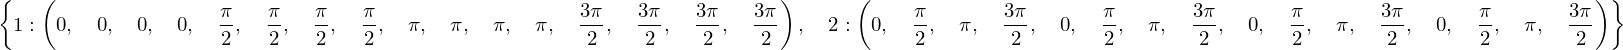

In [18]:
phases = [i*sy.pi/2 for i in range(4)]
phiv = {i+1: v for i, v in enumerate(zip(*list(product(phases, repeat=2))))}
phiv

### B2: -1, 1 ,1

In [19]:
pc_exp = {1: -1, 2: 1, 3: 1} # phase cycle exponents, alpha, beta, gamma
factors = [reduce(mul, [sy.exp(-sy.I*pc_exp[i]*phiv[i][j]) for i in sorted(phiv.keys())]) for j in range(len(phases)**2)]
factors

In [20]:
# prepare chopping:
a = {i+1: v for i, v in enumerate(sy.symbols('a1:4', real=True, nonnegative=True))}
phi = {i+1: v for i, v in enumerate(sy.symbols('\phi_1:4', real=True))}
detected = detected.subs([(amps[i], a[i]*sy.exp(sy.I*phi[i])) for i in amps.keys()])

In [21]:
# looking for 1-23
repr(detected.args[2])
filter(lambda s: "-k_1+k_2+k_2" in repr(s), detected.args)

In [23]:
len(detected.args)

In [22]:
sig = sum([f*detected.subs(
    [
            (phi[1], p1),
            (phi[2], p2)
        ]) for f, p1, p2 in zip(factors, phiv[1], phiv[2])]).simplify().expand(basic=True)
print(len(sig.args))
sig

21


### chopping third pulse

In [100]:
phiv_c = {i: list(chain(*repeat(phiv[i], 2))) for i in phiv.keys()}
factors_c = factors[:]
factors_c.extend([-f for f in factors])
a3 = [1]*16 + [0]*16
sig_c = sum([f*detected.subs(
    [
            (phi[1], p1),
            (phi[2], p2),
            (a[3], c_f3)
        ]) for f, c_f3, p1, p2 in zip(factors_c, a3, phiv_c[1], phiv_c[2])]).simplify().expand(basic=True)
len(sig_c.args)

In [103]:
sig_c

In [102]:
len(factors_c)

In [86]:
len(sig.args)

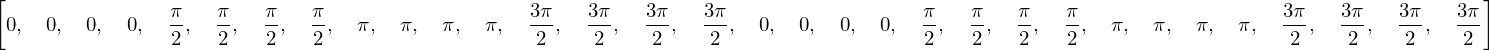

In [80]:
phiv_c[1]

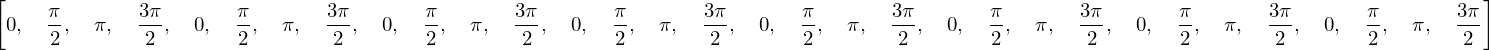

In [81]:
phiv_c[2]

In [82]:
factors_c

In [83]:
a3